In [38]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import optuna
import seaborn as sns

In [39]:
# load in 2022 mlb season data

df = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_processed.csv")

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_processed.csv")

In [40]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [41]:
# load in calculated expected metrics

xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\pfx_2022&3_xpfx.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\IVB_2022&3_xpfz.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\axis_2022&3_xaxis.csv")
xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\swing_2022&3_xswing.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\whiff_2022&3_xwhiff.csv")
xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\ld_2022&3_xld.csv")
xfoul = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\foul_2022&3_xfoul.csv")
xcs = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\cs_2022&3_xcalledstrike.csv")

In [42]:
# rename and drop columns from expected dfs

xpfx_x = xpfx_x[['pitch_id_raw', 'xpfx_x']]
xpfx_z = xpfx_z[['pitch_id_raw', 'xpfx_z']]
xspin_axis = xspin_axis[['pitch_id_raw', 'diff']]
xswing = xswing[['pitch_id_raw', 'xswing']]
xwhiff = xwhiff[['pitch_id_raw', 'xwhiff']]
xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]
xfoul = xfoul[['pitch_id_raw', 'xfoul']]
xcs = xcs[['pitch_id_raw', 'xcs']]

In [43]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs 11/10 took out cutters

df = df[df['pitch_type'].isin(['FF', 'SI', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [44]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs 11/10 took out cutters

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column
df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column
df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [45]:
pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "SP",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN", "FA": "FF", "FT": "SI"
    }

df_2023['pitch_type'] = df_2023['pitch_type'].map(pitch_type_map)
df['pitch_type'] = df['pitch_type'].map(pitch_type_map)

In [46]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [47]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [48]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [49]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [50]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')

df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')
df = pd.merge(df, xfoul, on='pitch_id_raw', how='left')
df = pd.merge(df, xcs, on='pitch_id_raw', how='left')


# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')

df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfoul, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xcs, on='pitch_id_raw', how='left')

In [51]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['xswing'] < 0, 'xswing'] = 0
df_2023.loc[df_2023['xswing'] < 0, 'xswing'] = 0

In [52]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['xswing'] * df['xwhiff']
df_2023['swing_whiff'] = df_2023['xswing'] * df_2023['xwhiff']

In [53]:
#df.to_csv(r'Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\optuna_big_csvs\fb_model_optuna.csv')

In [54]:
# feature selection and data splitting

columns = ['outcome', 'player_name', 'pitch_type', 'spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xwhiff', 'xswing', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'delta_run_exp', 'rolling_avg_velo']

features = ['spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xwhiff', 'xswing', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'rolling_avg_velo']

# drop any rows with nan values

df = df[columns]
df = df.dropna()

# create features and targets

X = df[features]
y = df['outcome']


In [55]:
# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# optuna tuning block

#def objective(trial):
    
    # define hyperparameters
    
    #params = {
        #'max_depth': trial.suggest_int('max_depth', 3, 9),
        #'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        #'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        #'objective': 'multi:softmax',
        #'num_class': len(np.unique(y_train)),
        #'eval_metric': 'mlogloss',
        #'use_label_encoder': False
    #}

    # initialize model
    
    #model = xgb.XGBClassifier(**params, n_estimators=100)

    # train the model
    
    #model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # predict on validation set
    
    #y_valid_pred = model.predict_proba(X_valid)

    # calculate log loss on the validation set
    
    #loss = log_loss(y_valid, y_valid_pred)

    #return loss

#create an optuna study and specifcy the the direction of the optimization

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

# print best parameters

#print(study.best_params)

In [57]:
# set up model

params = {
        'max_depth': 6,
        'eta': 0.14563827297914353,
        'subsample': 0.8282415405044197,
        'colsample_bytree': 0.9862628505253747,
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

# initialize model
    
model = xgb.XGBClassifier(**params, n_estimators=100)

# train model

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9862628505253747, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.14563827297914353, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=11, ...)

In [58]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.47992797983435365
Confusion Matrix:
[[18157     0     0     7  1631     0     0  1782     3     0     1]
 [   72     0     0     4   371     0     0   340     1     0     0]
 [   56     0     0     1   177     0     0   159     0     0     0]
 [  979     0     0    28  4096     0     0  2827     0     0     0]
 [ 2336     0     0    43  8112     0     0  4162     4     0     0]
 [   35     0     0     4   273     0     0   193     0     0     0]
 [  352     0     0    17  1338     0     0   991     0     0     0]
 [ 2482     0     0    31  5974     0     0  7022     2     0     0]
 [ 1055     0     0     4  1315     0     0   936     0     0     1]
 [    6     0     0     0    28     0     0    26     0     0     0]
 [ 1730     0     0     1   134     0     0   126     0     0     0]]


<Figure size 1000x5000 with 0 Axes>

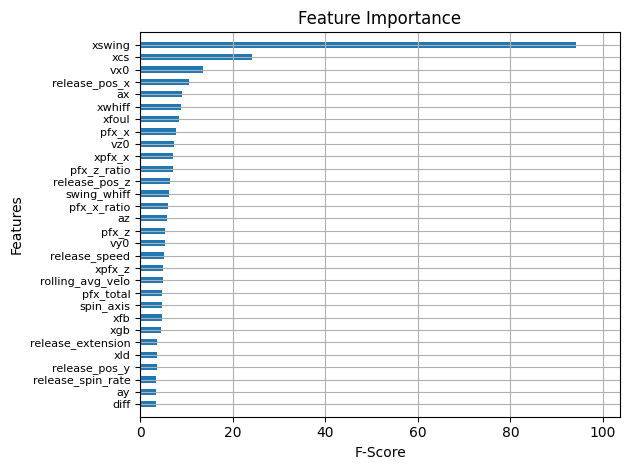

In [59]:
# plot feature importance

plt.figure(figsize=(10, 50))
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  
plt.tight_layout()
plt.savefig('fb_feature_importance.png', dpi=300)
plt.show()

In [60]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

xswing: 94.23981475830078
xcs: 24.121370315551758
vx0: 13.699954986572266
release_pos_x: 10.546594619750977
ax: 8.977499008178711
xwhiff: 8.888639450073242
xfoul: 8.4269380569458
pfx_x: 7.788051128387451
vz0: 7.408438682556152
xpfx_x: 7.163206577301025
pfx_z_ratio: 7.1395769119262695
release_pos_z: 6.517249584197998
swing_whiff: 6.184225559234619
pfx_x_ratio: 6.051178932189941
az: 5.781270980834961
pfx_z: 5.492492198944092
vy0: 5.492001056671143
release_speed: 5.099417686462402
xpfx_z: 4.885416030883789
rolling_avg_velo: 4.867692470550537
pfx_total: 4.852619171142578
spin_axis: 4.804324626922607
xfb: 4.703508377075195
xgb: 4.535569667816162
release_extension: 3.6602487564086914
xld: 3.6140666007995605
release_pos_y: 3.5723118782043457
release_spin_rate: 3.537607192993164
ay: 3.4638402462005615
diff: 3.4560341835021973


In [61]:
# copy and keep only features

df_2023_features = df_2023[features]

# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [62]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [63]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [64]:
def reformat_name(name):
    parts = name.split(', ')
    if len(parts) == 2:
        return parts[1] + ' ' + parts[0]
    else:
        return name

df['player_name'] = df['player_name'].apply(reformat_name)
df_2023['player_name'] = df_2023['player_name'].apply(reformat_name)

In [65]:
# group by player name and pitch type for pitches a player threw more than 150 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 150)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\Bottom 10:")
print(bottom_10)

Top 10:
          player_name pitch_type  pitch_quality
538      Ryan Helsley         FF      -0.025743
53    Aroldis Chapman         SI      -0.022128
503       Paul Sewald         FF      -0.019057
221    Félix Bautista         FF      -0.018087
94   Brusdar Graterol         SI      -0.017121
216        Eury Pérez         FF      -0.015643
272      Jacob deGrom         FF      -0.014675
607     Trevor Megill         FF      -0.014071
573   Spencer Strider         FF      -0.013897
187    Drew Rasmussen         FF      -0.013030
\Bottom 10:
         player_name pitch_type  pitch_quality
13   Adam Wainwright         FF       0.021307
364     José Soriano         SI       0.016448
93      Brooks Raley         SI       0.015984
171     Dany Jiménez         FF       0.015265
404   Kyle Hendricks         FF       0.015252
235  Graham Ashcraft         SI       0.014784
288    Jared Shuster         FF       0.014714
549         Sam Moll         FF       0.013970
113  Carlos Carrasco         

In [66]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,Ryan Helsley,FF,235
2,Aroldis Chapman,SI,217
3,Paul Sewald,FF,202
4,Félix Bautista,FF,197
5,Brusdar Graterol,SI,192
6,Eury Pérez,FF,184
7,Jacob deGrom,FF,180
8,Trevor Megill,FF,177
9,Spencer Strider,FF,176
10,Drew Rasmussen,FF,171


In [67]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Fastball Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig('fb_stuff_plus_rankings.png', dpi=300)
plt.close()

In [68]:
# save 2022 and 2023 dfs to y drive

#df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures_outcome_probs_stuff_plus.csv")
#df_2023.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_MLB_xfeatures__outcome_probs_stuff_plus.csv")

In [69]:
# heater avg metrics function for breaking ball model

#def heater_stats(df):
    #grouped_df = df.groupby(['player_name', 'pitch_type'])[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'xpfx_x', 'pfx_z', 'xpfx_z', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'release_spin_rate', 'release_extension', 'spin_axis']].mean().reset_index()
    #idx = grouped_df.groupby(['player_name'])['release_speed'].transform(max) == grouped_df['release_speed']
    #heater_df = grouped_df[idx]
    #heater_df = heater_df.groupby('player_name').head(1).reset_index(drop=True)
    #final_df = heater_df.rename(columns={col: f'fb_{col}' if col != 'player_name' else col for col in heater_df.columns})
    #return final_df

#heaters_2022 = heater_stats(df)
#heaters_2022[heaters_2022['player_name'] == 'Fairbanks, Pete']

In [70]:
# group by pitcher and pitch type

pp = df_2023.groupby(['player_name', 'pitch_type'])

# calculate sum of delta run expectancy and count of pitches for each pitcher's pitch

rv = pp.agg(total_delta_run_exp=('delta_run_exp', 'sum'),
                      total_pitches=('delta_run_exp', 'count'))

# calculate run value per 100 pitches

rv['run_value_per_100_pitches'] = (rv['total_delta_run_exp'] / rv['total_pitches']) * 100

# filter for pitches thrown at least 200 times and sort

rv = rv[rv['total_pitches'] > 150]
rv = rv.sort_values(by='run_value_per_100_pitches')

# merge with sorted pitch quality sum on player name and pitch type

model_validation_df = pd.merge(sorted_pitch_quality_sum, rv, on=['player_name', 'pitch_type'], how='left')

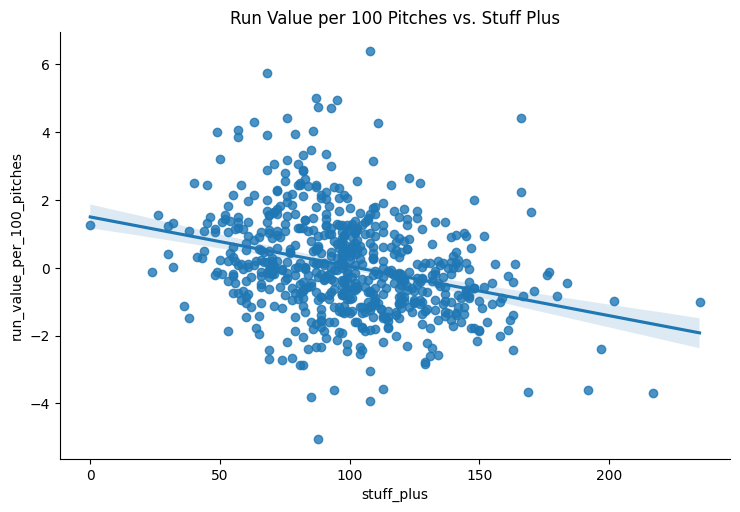

In [71]:
# scatter plot with a regression line

sns.lmplot(x='stuff_plus', y='run_value_per_100_pitches', data=model_validation_df, aspect=1.5)
plt.title('Run Value per 100 Pitches vs. Stuff Plus')
plt.savefig('fb_validation_plot.png', dpi=300)
plt.show()

In [72]:
# correlation coefficient

correlation = model_validation_df['stuff_plus'].corr(model_validation_df['run_value_per_100_pitches'])
print(f"Correlation Coefficient: {correlation}")


from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

slope, intercept, r_value, p_value, std_err = stats.linregress(model_validation_df['stuff_plus'], model_validation_df['run_value_per_100_pitches'])
predicted_values = slope * model_validation_df['stuff_plus'] + intercept

# mse and rmse

mse = mean_squared_error(model_validation_df['run_value_per_100_pitches'], predicted_values)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# rsquared

r_squared = r2_score(model_validation_df['run_value_per_100_pitches'], predicted_values)
print(f"R-squared: {r_squared}")

Correlation Coefficient: -0.29841370801449946
Mean Squared Error: 2.058973059605701
Root Mean Squared Error: 1.4349122132052892
R-squared: 0.08905074113096278


In [73]:
# get pitch count for each pitcher's pitches

pitch_counts = df_2023.groupby(['player_name', 'pitch_type']).size()
count_df = pitch_counts.reset_index(name='count')

# merge pitch counts on pitch quality sum to get stuff plus and pitch count on the same df

fb_clean = pd.merge(pitch_quality_sum, count_df, on=['player_name', 'pitch_type'], how='left')
fb_clean['stuff_plus'] = fb_clean['stuff_plus'].astype(int)
fb_clean = fb_clean[['player_name', 'pitch_type', 'stuff_plus', 'count']]
fastball_ready = fb_clean.sort_values(by='stuff_plus', ascending=False)

In [74]:
# save to y drive

fastball_ready.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\polished_dfs\fastball_ready.csv")